In [1]:
import nbodypy as npy
import numpy as np
from galpy.potential import MWPotential2014
import matplotlib.pyplot as plt

In [85]:
test=np.linspace(0,10,11)
test

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [88]:
np.cumsum(test)

array([ 0.,  1.,  3.,  6., 10., 15., 21., 28., 36., 45., 55.])

In [87]:
np.cumsum(test)[5]

15.0

In [2]:
def stream_path_match(cluster,dt=0.1,nt=100,pot=MWPotential2014,from_centre=False,r0=8.,v0=220.):

    units0,origin0=save_cluster(cluster)
    cluster.to_galaxy()
    cluster.to_realkpc()

    ts,x,y,z,vx,vy,vz=stream_path(cluster,dt=dt,nt=nt,pot=pot,from_centre=False,r0=8.,v0=220.)

    pindx=np.argmin(np.fabs(ts-dt))
    print('DEBUG: ',pindx,ts[pindx])

    dx=np.tile(x,cluster.ntot).reshape(cluster.ntot,len(ts))-np.repeat(cluster.x,len(ts)).reshape(cluster.ntot,len(ts))
    dy=np.tile(y,cluster.ntot).reshape(cluster.ntot,len(ts))-np.repeat(cluster.y,len(ts)).reshape(cluster.ntot,len(ts))
    dz=np.tile(z,cluster.ntot).reshape(cluster.ntot,len(ts))-np.repeat(cluster.z,len(ts)).reshape(cluster.ntot,len(ts))
    dr=np.sqrt(dx**2.+dy**2.+dz**2.)
    
    indx=np.argmin(dr,axis=1)
    tstar=ts[indx]*bovy_conversion.time_in_Gyr(ro=r0,vo=v0)


    dprog=[]
    dstream=np.array([])

    for i in range(0,cluster.ntot):
        if indx[i]==pindx:
            dprog.append(0.)
        elif indx[i] > pindx:

            xdiff=x-x[indx[i]]
            ydiff=y-y[indx[i]]
            zdiff=z-z[indx[i]]

            dxi=xdiff[pindx:indx[i]]-xdiff[pindx+1:indx[i]+1]
            dyi=ydiff[pindx:indx[i]]-ydiff[pindx+1:indx[i]+1]
            dzi=zdiff[pindx:indx[i]]-zdiff[pindx+1:indx[i]+1]
            dprog.append(np.sqrt(np.cumsum(np.fabs(dx))[-1]**2.+np.cumsum(np.fabs(dy))[-1]**2.+np.cumsum(np.fabs(dz))[-1]**2.))            
        else:   

            xdiff=x-x[pindx]
            ydiff=y-y[pindx]
            zdiff=z-z[pindx]

            dxi=xdiff[indx[i]:pindx]-xdiff[indx[i]+1:pindx+1]
            dyi=ydiff[indx[i]:pindx]-ydiff[indx[i]+1:pindx+1]
            dzi=zdiff[indx[i]:pindx]-zdiff[indx[i]+1:pindx+1]
            dprog.append(-1.*np.sqrt(np.cumsum(np.fabs(dx))[-1]**2.+np.cumsum(np.fabs(dy))[-1]**2.+np.cumsum(np.fabs(dz))[-1]**2.))

        #Find distance to orbit path
        dxi=dx[i,:]
        dyi=dy[i,:]
        dzi=dz[i,:]
        dri=np.column_stack([dxi,dyi,dzi])
        absdri=np.sqrt(dxi**2.+dyi**2.+dzi**2.)


        if indx[i]==len(dxi)-1:
            ovec=np.array([x[indx[i]]-x[indx[i]-1],y[indx[i]]-y[indx[i]-1],z[indx[i]]-z[indx[i]-1]])
        elif indx[i]==0:
            ovec=np.array([x[indx[i]+1]-x[indx[i]],y[indx[i]+1]-y[indx[i]],z[indx[i]+1]-z[indx[i]]])
        elif absdri[indx[i]+1] < absdri[indx[i]-1]:
            ovec=np.array([x[indx[i]+1]-x[indx[i]],y[indx[i]+1]-y[indx[i]],z[indx[i]+1]-z[indx[i]]])
        else:
            ovec=np.array([x[indx[i]]-x[indx[i]-1],y[indx[i]]-y[indx[i]-1],z[indx[i]]-z[indx[i]-1]])

        absovec=np.sqrt(ovec[0]**2.+ovec[1]**2.+ovec[2]**2.)

        theta=np.arccos(np.dot(ovec,dri[indx[i]])/(absovec*absdri[indx[i]]))
        dstream=np.append(dstream,absdri[indx[i]]*np.sin(theta))
     
        if indx[i]==len(dxi)-1 or indx[i]==0:
            pass
        elif absdri[indx[i]+1] < absdri[indx[i]-1]:
            if indx[i] >= pindx:
                dprog[-1]+=absdri[indx[i]]*np.cos(theta)
            else:
                dprog[-1]-=absdri[indx[i]]*np.cos(theta)

        elif absdri[indx[i]+1] > absdri[indx[i]-1]:
            if indx[i] < pindx:
                dprog[-1]+=absdri[indx[i]]*np.cos(theta)
            else:
                dprog[-1]-=absdri[indx[i]]*np.cos(theta)

    #Assign negative to stars with position vectors in opposite direction as local angular momentum vector
    rgc=np.column_stack([x[indx],y[indx],z[indx]])
    vgc=np.column_stack([vx[indx],vy[indx],vz[indx]])
    lz=np.cross(rgc,vgc)

    rstar=np.column_stack([cluster.x-x[indx],cluster.y-y[indx],cluster.z-z[indx]])

    ldot=np.sum(rstar*lz,axis=1)
    dstream[ldot<0]*=-1 

    return_cluster(cluster,units0,origin0)

    return np.array(tstar),np.array(dprog),np.array(dstream)

In [3]:
cluster=npy.load_cluster('nbodypy',units='realpc',origin='cluster',nsnap=600,snapbase='fort_',delimiter=',',ofilename='Norbit.dat',ounits='realpc')
cluster.to_realkpc()
cluster.to_galaxy()

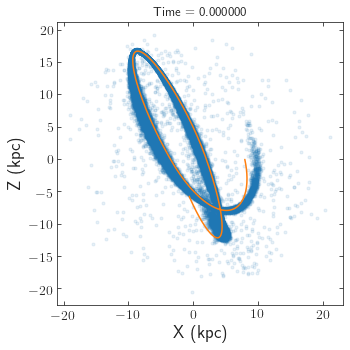

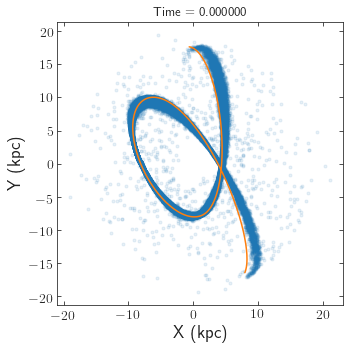

In [72]:
t,x,y,z,vx,vy,vz,o=npy.orbital_path(cluster,dt=0.3)

npy.starplot(cluster,'xz')
npy.nlplot(x,z,overplot=True)


npy.starplot(cluster,'xy')
npy.nlplot(x,y,overplot=True)

plt.show()

In [73]:
print(t)

[0.    0.003 0.006 0.009 0.012 0.015 0.018 0.021 0.024 0.027 0.03  0.033
 0.036 0.039 0.042 0.045 0.048 0.051 0.054 0.057 0.06  0.063 0.066 0.069
 0.072 0.075 0.078 0.081 0.084 0.087 0.09  0.093 0.096 0.099 0.102 0.105
 0.108 0.111 0.114 0.117 0.12  0.123 0.126 0.129 0.132 0.135 0.138 0.141
 0.144 0.147 0.15  0.153 0.156 0.159 0.162 0.165 0.168 0.171 0.174 0.177
 0.18  0.183 0.186 0.189 0.192 0.195 0.198 0.201 0.204 0.207 0.21  0.213
 0.216 0.219 0.222 0.225 0.228 0.231 0.234 0.237 0.24  0.243 0.246 0.249
 0.252 0.255 0.258 0.261 0.264 0.267 0.27  0.273 0.276 0.279 0.282 0.285
 0.288 0.291 0.294 0.297 0.3   0.303 0.306 0.309 0.312 0.315 0.318 0.321
 0.324 0.327 0.33  0.333 0.336 0.339 0.342 0.345 0.348 0.351 0.354 0.357
 0.36  0.363 0.366 0.369 0.372 0.375 0.378 0.381 0.384 0.387 0.39  0.393
 0.396 0.399 0.402 0.405 0.408 0.411 0.414 0.417 0.42  0.423 0.426 0.429
 0.432 0.435 0.438 0.441 0.444 0.447 0.45  0.453 0.456 0.459 0.462 0.465
 0.468 0.471 0.474 0.477 0.48  0.483 0.486 0.489 0.

In [74]:
pindx=np.argmin(np.sqrt((x-cluster.xgc)**2.+(y-cluster.ygc)**2.+(z-cluster.zgc)**2.))
print(pindx,len(x),t[pindx])

100 201 0.29999999999999993


In [75]:
print(x)
print(x[pindx])

[ 7.92430993  7.99978585  8.06609366  8.12302579  8.17036985  8.20790655
  8.23540893  8.25264169  8.2593607   8.25531249  8.24023378  8.21385105
  8.17588016  8.12602593  8.06398193  7.98943029  7.90204163  7.80147521
  7.68737929  7.55939179  7.41714142  7.26024918  7.08833067  6.90099918
  6.69786983  6.47856513  6.24272213  5.9900018   5.72010084  5.43276668
  5.127816    4.8051575   4.46481904  4.10697938  3.7320039   3.3404828
  2.93326927  2.51151325  2.07668528  1.63058406  1.17532189  0.71328474
  0.24706786 -0.22060745 -0.68698681 -1.14937485 -1.6052173  -2.05216696
 -2.48813068 -2.91129778 -3.32015444 -3.71352513 -4.09088176 -4.45232249
 -4.7981049  -5.12853771 -5.4439551  -5.74470234 -6.03112653 -6.30357056
 -6.56236919 -6.80784651 -7.04031449 -7.26007209 -7.46740498 -7.66258544
 -7.8458726  -8.01751277 -8.17773984 -8.32677583 -8.4648313  -8.59210598
 -8.70878925 -8.81506062 -8.91109028 -8.99703957 -9.0730614  -9.13930072
 -9.19589493 -9.24297422 -9.28066202 -9.30907526 -9.

In [76]:
dx=(np.fabs(x[0:-2]-x[1:-1]))

In [106]:
dist=[]
print(len(x),pindx,dx[pindx])
for i in range(0,len(x)):
    indx=i

    if indx==0:
        d=np.cumsum(dx)[pindx-1]
    elif indx<=pindx:
        if i==1:
            print(np.cumsum(dx)[pindx-1],np.cumsum(dx)[indx-1])
        d=np.cumsum(dx)[pindx-1]-np.cumsum(dx)[indx-1]
    elif indx < len(dx):
        d=np.cumsum(dx)[indx-1]-np.cumsum(dx)[pindx-1]
    elif indx==len(dx):
        d=np.cumsum(dx)[-1]-np.cumsum(dx)[pindx-1]

    dist.append(d)
    
print(len(x),len(dist),dist[pindx])
print(dist)

201 100 0.14006952868281353
19.0694414059899 0.0754759181095439
201 201 0.0
[19.0694414059899, 18.993965487880356, 18.9276576782873, 18.8707255428075, 18.82338148667934, 18.78584477988472, 18.758342400982322, 18.741109641307293, 18.734390634063708, 18.730342419607886, 18.715263709919057, 18.688880987670267, 18.650910090027146, 18.60105585917602, 18.539011865059813, 18.464460226783054, 18.37707156711932, 18.276505144502288, 18.162409219359944, 18.03442172730271, 17.892171351253513, 17.735279108969454, 17.56336060249347, 17.376029112840193, 17.17289976747216, 16.95359506024053, 16.71775206289474, 16.46503173167305, 16.195130776389377, 15.907796612119245, 15.602845936132072, 15.28018743412989, 14.939848973030212, 14.582009317074434, 14.207033830624436, 13.815512730608729, 13.4082992004797, 12.986543179079066, 12.551715213679554, 12.105613998042935, 11.65035182488983, 11.188314670365354, 10.722097797334877, 10.254422486171572, 9.788043118650828, 9.325655078527344, 8.86981262927598, 8.42286

In [117]:
dist2=np.zeros(len(x))
dist2[0]=np.cumsum(dx)[pindx-1]
dist2[1:pindx+1]=np.cumsum(dx)[pindx-1]-np.cumsum(dx)[0:pindx]
dist2[pindx+1:-1]=np.cumsum(dx)[pindx:]-np.cumsum(dx)[pindx-1]
dist2[-1]=np.cumsum(dx)[-1]-np.cumsum(dx)[pindx-1]
print(np.cumsum(dx)[pindx-1],np.cumsum(dx)[0])

print(dist2)


98 97
19.0694414059899 0.0754759181095439
[19.06944141 18.99396549 18.92765768 18.87072554 18.82338149 18.78584478
 18.7583424  18.74110964 18.73439063 18.73034242 18.71526371 18.68888099
 18.65091009 18.60105586 18.53901187 18.46446023 18.37707157 18.27650514
 18.16240922 18.03442173 17.89217135 17.73527911 17.5633606  17.37602911
 17.17289977 16.95359506 16.71775206 16.46503173 16.19513078 15.90779661
 15.60284594 15.28018743 14.93984897 14.58200932 14.20703383 13.81551273
 13.4082992  12.98654318 12.55171521 12.105614   11.65035182 11.18831467
 10.7220978  10.25442249  9.78804312  9.32565508  8.86981263  8.42286297
  7.98689925  7.56373216  7.15487549  6.76150481  6.38414817  6.02270744
  5.67692503  5.34649222  5.03107483  4.73032759  4.4439034   4.17145937
  3.91266074  3.66718342  3.43471544  3.21495784  3.00762495  2.8124445
  2.62915733  2.45751717  2.29729009  2.14825411  2.01019863  1.88292395
  1.76624069  1.65996932  1.56393965  1.47799036  1.40196853  1.33572921
  1.279135

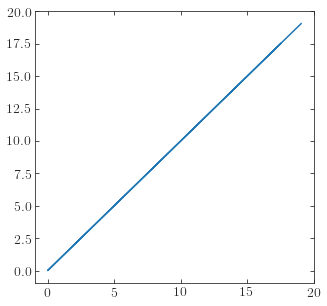

In [118]:
plt.plot(dist,dist2)
plt.show()

In [10]:
print(np.cumsum(dxtrailing)[0])

0.0754759181095439


In [11]:
tindx=np.linspace(1,len(dxtrailing)-1,len(dxtrailing)-1).astype(int)
lindx=np.linspace(len(dxtrailing)+2,len(dxtrailing)+len(dxleading),len(dxleading)-1).astype(int)

print(len(tindx),len(dxtrailing))
print(tindx)
print(lindx)
print(len(x))
dist2=np.zeros(len(x))

99 100
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]
[102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200]
201


In [12]:
dist2[0]=np.cumsum(dxtrailing)[-1]
dist2[tindx]=np.cumsum(dxtrailing)[-1]-np.cumsum(dxtrailing)[tindx-1]
dist2[pindx]=0.
dist2[pindx+1]=np.cumsum(dxleading)[0]
dist2[lindx]=np.cumsum(dxleading)[lindx-lindx[0]]-np.cumsum(dxleading)[0]

In [13]:
print(dist2,len(dist2))
print(dist2[pindx])

[19.06944141 18.99396549 18.92765768 18.87072554 18.82338149 18.78584478
 18.7583424  18.74110964 18.73439063 18.73034242 18.71526371 18.68888099
 18.65091009 18.60105586 18.53901187 18.46446023 18.37707157 18.27650514
 18.16240922 18.03442173 17.89217135 17.73527911 17.5633606  17.37602911
 17.17289977 16.95359506 16.71775206 16.46503173 16.19513078 15.90779661
 15.60284594 15.28018743 14.93984897 14.58200932 14.20703383 13.81551273
 13.4082992  12.98654318 12.55171521 12.105614   11.65035182 11.18831467
 10.7220978  10.25442249  9.78804312  9.32565508  8.86981263  8.42286297
  7.98689925  7.56373216  7.15487549  6.76150481  6.38414817  6.02270744
  5.67692503  5.34649222  5.03107483  4.73032759  4.4439034   4.17145937
  3.91266074  3.66718342  3.43471544  3.21495784  3.00762495  2.8124445
  2.62915733  2.45751717  2.29729009  2.14825411  2.01019863  1.88292395
  1.76624069  1.65996932  1.56393965  1.47799036  1.40196853  1.33572921
  1.27913501  1.23205571  1.19436792  1.16595468  1.

In [14]:
print(dist/dist2)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.

[  0.92848679   0.9321763    0.93544192   0.93826411   0.94062401
   0.9425035    0.94388535   0.94475327   0.9450921    0.94529636
   0.94605798   0.94739351   0.94932228   0.95186664   0.95505222
   0.95890832   0.96346823   0.96876971   0.9748555    0.9817739
   0.98957942   0.99833357   1.00810573   1.01897415   1.03102707
   1.04436401   1.05909721   1.0753532    1.09327456   1.11302181
   1.13477532   1.15873739   1.1851341    1.21421706   1.24626468
   1.28158287   1.32050488   1.36339011   1.41062191   1.46260442
   1.51975878   1.58251936   1.65133026   1.72664278   1.80891362
   1.89860384   1.99617797   2.10210288   2.21684586   2.34087143
   2.47463768   2.61860711   2.77338872   2.93982809   3.11889349
   3.31165253   3.51927274   3.7430229    3.98427304   4.24449166
   4.52523888   4.82815352   5.15493